# TO-DO

We need to try/finish to do:
- 1 Group: 
    - Implement attention map.
    - Try patchyfing with convolutions.
    - Find out how Tensorboard works. 
- 2 Group:
    - Try Ensemble on Classification (Potential Bright Idea :) 
    - Try different versions of Attention (ARPR).
    - Try different versions of Embedding (LaPE, 2D Positional Embeddings). 

- Others:
    - Make a version with MNIST. 
    - Put LogSoftmax also in the MHSA? 
    - Retry to use Augmentation. 
    - Start writing Report. 

# (AdaViT) ADAPTIVE VISION TRANSFORMERS

### SAPIENZA UNIVESITY of ROME (DEPARTMENT OF COMPUTER, CONTROL AND MANAGEMENT ENGINEEERING)

### COURSE IN ARTIFICIAL INTELLIGENCE AND ROBOTICS (ACADEMIC YEAR 2023/2024)

### NEURAL NETWORK's PROJECT
- Professors: SIMONE SCARDAPANE, DANILO COMMINIELLO 

### AUTHORS:
- **ALESSIO BORGI**
    - University ID: 1952442
    - Email: borgi.1952442@studenti.uniroma.it
- **ANGELO GIANFELICE**
    - University ID: 1851260
    - Email: gianfelice.1851260@studenti.uniroma.it
    
### 

## TABLE OF CONTENTS:
- **0: IMPORTING LIBRARIES AND SETTING THE SEEDS**
- **1: DATASET INSPECTION**
    - **1.1: CREATION OF THE LABEL DICTIONARY**
    - **1.2: DISPLAYING EXAMPLES OF THE DATASET (ENCODED LABELS)**
    - **1.3: DISPLAYING EXAMPLES OF THE DATASET (DECODED LABELS)**
- **2:**
- **3:**
- **4:**
- **5:** 
- **6:** 

## INTRODUCTION

### (ViT) Vision Transformer's Idea

In this Notebook, we aim to present a clever implementation of **Vision Transformers (ViT)**. The Vision Transformer (ViT) represents a paradigm in computer vision by leveraging transformer-based architectures for **Image Classification** tasks. 

Unlike traditional **Convolutional Neural Networks (CNNs)**,which rely on local receptive fields (**Locality Principle**) and **Hierarchical Feature Extraction** through convolutional layers, ViT dispenses with the conventional convolutional layers and adopts a **Transformer Model**, originally designed for sequential data processing, such as in NLP("Natural Language Processing"). 

If we look this idea with a birds-eye point of view, we have that ViT's core idea involves treating an input image as a sequence of non-overlapping fixed-size patches, linearly embeds them, and appends learnable positional embeddings, that are added to encode spatial information. The resulting sequence of patch embeddings is then fed into a stack of transformer encoder blocks. Each transformer block consists of multi-head self-attention mechanisms and feedforward neural networks, enabling the model to capture both local and global contextual information, enhancing the model's ability to recognize complex patterns and relationships. 

One **ViT's distinguishing Feature** is its ability to **capture Long-Range Dependencies in Images** through self-attention, facilitating understanding of the visual content. This stands in contrast to CNNs, which may struggle with information propagation across distant image regions due to the locality of convolutional operations. ViT's self-attention mechanism allows it to efficiently model relationships between distant patches, promoting effective feature learning for image recognition. Moreover, ViT exhibits promising **Scalability Advantages**, particularly when dealing with large datasets and high-resolution images. The absence of spatial hierarchies in ViT's architecture enables more straightforward parallelization, facilitating training on powerful hardware accelerators. This scalability, coupled with competitive performance on standard image classification benchmarks, positions ViT as a versatile and efficient alternative to traditional CNN-based approaches.


### (AdaViT) Adaptive Vision Transformer's Modification
Despite their remarkable advantages, Vision Transformers (ViTs) often face **Challenges** due to their fixed 2D positional encodings. This rigidity limits their ability to adapt to input image sizes and variations, hindering their applicability to real-world scenarios. To address these shortcomings, **Adaptive Vision Transformers (AdaViT)** emerge as a promising solution, introducing a **Dynamic Attention Mechanism** that allows the model to **selectively  take into account only Relevant Regions of the Input Image**, thereby overcoming the spatial resolution limitations of traditional ViTs. 

AdaViT enhances the vision transformer block by integrating an **Adaptive Halting Module**, which computes a **Halting Probability for each Token**. Remarkably, this module leverages the existing block parameters and utilizes a single neuron from the last dense layer in each block to calculate the halting probability, introducing **no additional Parameters** and **no additional Computational Overhead**. Tokens are discarded upon meeting the halting condition. Through the adaptive halting of tokens, we selectively perform dense computations only on those tokens considered informative for the given task. Consequently, as the vision transformer progresses through successive blocks, fewer tokens are processed, resulting in accelerated inference. 

This improvements leads to immediate and significant **Speed-Up at Inference Time** on standard computational platforms, without the need for additional tuning.

### ABSTRACT & CONTRIBUTIONS

The **Vision Transformer (ViT)** has emerged as a powerful architecture for Image Classification, but it faces challenges related to computational efficiency and adaptability to varying levels of task complexity. In response to these challenges, we delve into **Adaptive Vision Transformer (A-ViT)**, a method designed to enhance the adaptability and computational efficiency of ViT models.

The core contribution of our work is...

### 0: IMPORTING LIBRARIES AND SETTING THE SEEDS

In this stage, we import essential libraries and modules, laying the groundwork for subsequent code implementation and experimentation. Additionally, this step emphasizes the establishment of seed values, practice done for ensuring reproducibility in data processing, model training, and evaluation. 

In [1]:

# Importing PyTorch-related Libraries.
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToPILImage
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchmetrics.classification import Accuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall

# Importing PyTorch Lightning-Related Libraries.
import pytorch_lightning as pl
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar, LearningRateMonitor, ModelCheckpoint

# Importing General Libraries.
import os
import csv
import PIL
import random
import numpy as np
from PIL import Image
import seaborn as sns
from pathlib import Path
from scipy.stats import norm
import matplotlib.pyplot as plt
from collections import OrderedDict


In [2]:

def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results.
    
    Arguments:
        - seed {int} : Number of the seed.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    pl.seed_everything(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# Set the seed.
seed_everything(31)

### 1: DATASET INSPECTION

We subsequently focus on experiencing a comprehensive exploration and understanding of the dataset at hand. This phase involves an in-depth examination of the data's structure, characteristics, and content. We delve into visualizing dataset images along with their corresponding labels. 

#### TINY IMAGENET
The **TinyImageNet** dataset is a subset of the 1.2 million images in ImageNet, specifically selected to be 20% as large as ImageNet while preserving the same distribution of classes. This makes it a more manageable dataset for our case where we have limited computational power, training and evaluating vision models, while still providing a challenging and diverse representation of real-world images.

TinyImageNet consists of **200 Classes, each** containing **640 Images**. The class distribution is similar to that of ImageNet, with a slight overrepresentation of animals and objects commonly found in everyday life. The images are downsampled to **64x64** pixels, making them smaller and less computationally expensive to handle than full-resolution ImageNet images.


#### 1.1: CREATION OF THE LABEL DICTIONARY

Here, we initiate the creation of a **Label Dictionary** to establish a meaningful mapping between encoded labels and their corresponding actual labels. The process extracts this from a file containing label information. The resulting dictionary serves as a key reference for interpreting encoded labels and facilitates a clearer understanding of the dataset's class labels. 

In [3]:

# Initialize the Mapping Dictionary to be empty.
mapping_dict = {}

# Open the file in read mode.
with open('/kaggle/input/tiny-imagenet/tiny-imagenet-200/words.txt', 'r') as file:
    
    # Read each line from the file.
    for line in file:
        # Split the line into tokens based on whitespace.
        tokens = line.strip().split('\t')
        
        # Check if there are at least two tokens.
        if len(tokens) >= 2:
            # Extract the encoded label (left) and actual label (right).
            encoded_label, actual_label = tokens[0], tokens[1]
            
            # Add the mapping to the dictionary.
            mapping_dict[encoded_label] = actual_label

# Print the mapping dictionary.
#print(mapping_dict)


#### 1.2: DISPLAYING EXAMPLES OF THE DATASET (ENCODED LABELS)

In this exploration code, we aim to load and explore the **Tiny ImageNet** dataset. After loading the dataset, the class names and their respective counts are extracted. We visualize a grid containing ten randomly selected images from the dataset, showcasing both the image itself and its associated **Class Label (Encoded)**. 

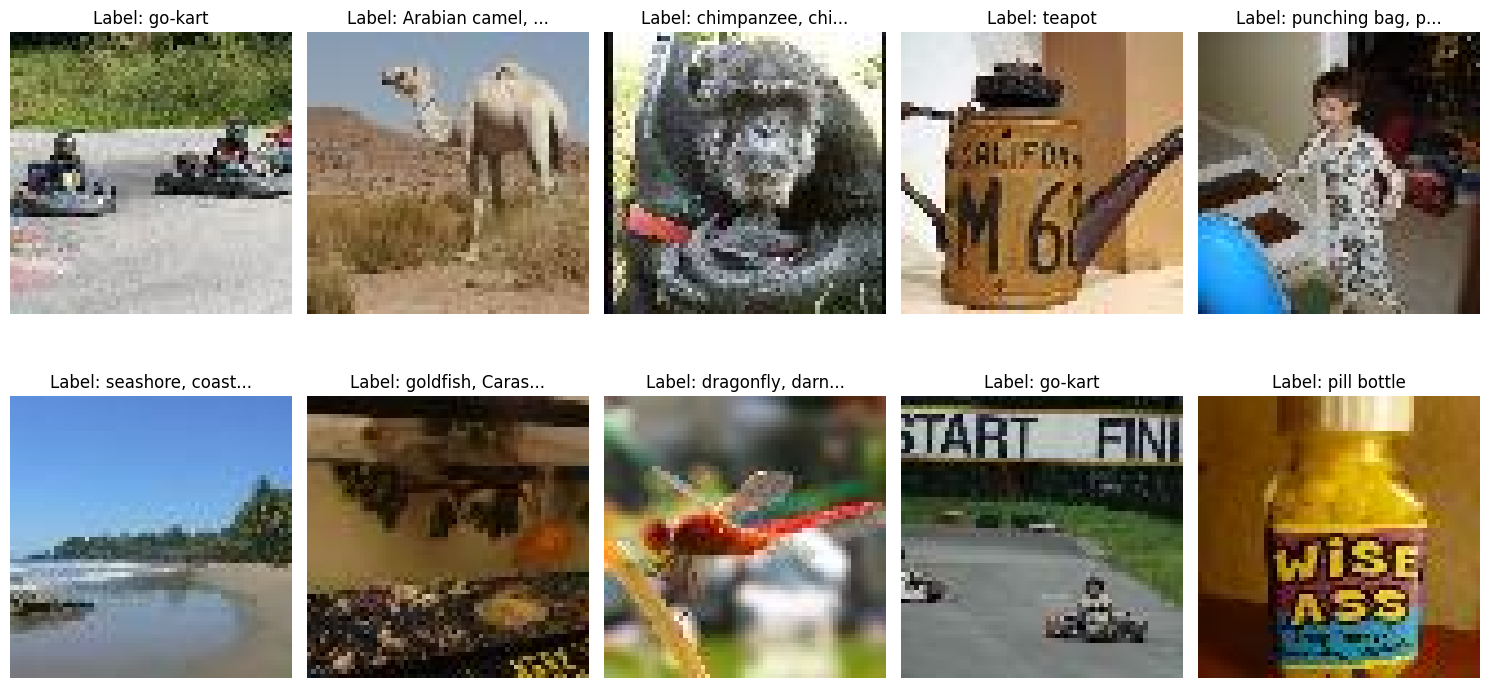

In [4]:

# Loading the dataset using ImageFolder.
dataset0 = datasets.ImageFolder(root="/kaggle/input/tiny-imagenet/tiny-imagenet-200/train/", transform=None)

# Extract class names and their counts.
class_names = dataset0.classes
class_counts = [dataset0.targets.count(i) for i in range(len(class_names))]

# Setting the seed.
np.random.seed(31)

# Create a grid of 10 images with labels.
plt.figure(figsize=(15, 8))

for i in range(10):
    
    # Randomly select an image and its corresponding label.
    index = np.random.randint(len(dataset0))
    image, encoded_label = dataset0[index]
    
    # Look up the actual label using the mapping dictionary.
    actual_label = mapping_dict.get(class_names[encoded_label], "Unknown Label")
    
    # Trim the label if it exceeds the maximum length.
    actual_label_trimmed = actual_label[:15] + '...' if len(actual_label) > 15 else actual_label

    # Display the image with its label..
    plt.subplot(2, 5, i+1)
    plt.imshow(np.array(image))  
    plt.title(f"Label: {actual_label_trimmed}", wrap=True)
    plt.axis('off')

# Displaying Dataset examples.
plt.tight_layout()
plt.show()

#### 1.3: DISPLAYING EXAMPLES OF THE DATASET (DECODED LABELS)

In this exploration code, we aim to load and explore the **Tiny ImageNet** dataset, together with the **(Decoded) Class Labels**, making use of the Label Dictionary extracted in *step 1.1*. 

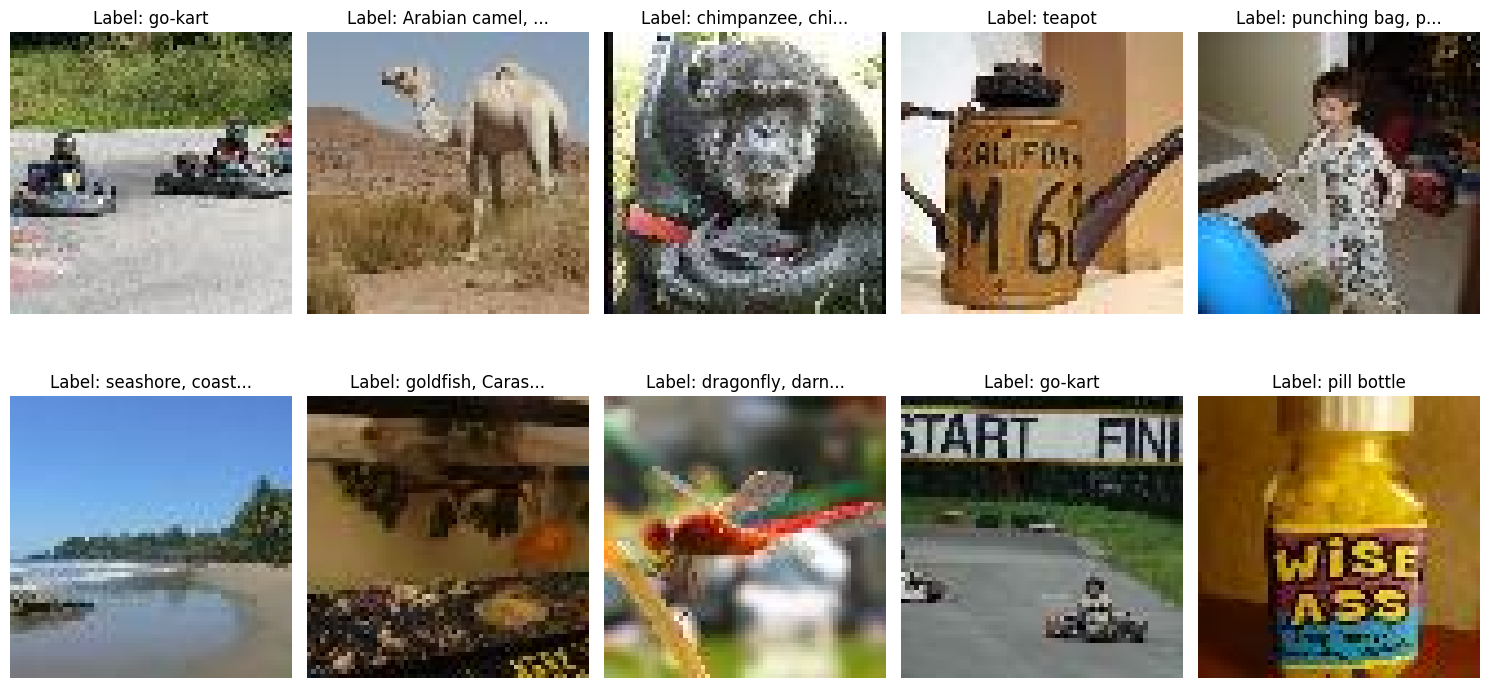

In [5]:

# Loading the dataset using ImageFolder.
dataset0 = datasets.ImageFolder(root="/kaggle/input/tiny-imagenet/tiny-imagenet-200/train/", transform=None)

# Extract class names and their counts.
class_names = dataset0.classes
class_counts = [dataset0.targets.count(i) for i in range(len(class_names))]

# Setting the seed.
np.random.seed(31)

# Create a grid of 10 images with labels.
plt.figure(figsize=(15, 8))

for i in range(10):
    
    # Randomly select an image and its corresponding label.
    index = np.random.randint(len(dataset0))
    image, encoded_label = dataset0[index]
    
    # Look up the actual label using the mapping dictionary.
    actual_label = mapping_dict.get(class_names[encoded_label], "Unknown Label")
    
    # Trim the label if it exceeds the maximum length.
    actual_label_trimmed = actual_label[:15] + '...' if len(actual_label) > 15 else actual_label

    # Display the image with its label..
    plt.subplot(2, 5, i+1)
    plt.imshow(np.array(image))  
    plt.title(f"Label: {actual_label_trimmed}", wrap=True)
    plt.axis('off')

# Displaying Dataset examples.
plt.tight_layout()
plt.show()

### 2: DATA-MODULE DEFINITION

#### 2.0: CUSTOMIZED TRANSFORM CLASS

In [6]:

class AdaViT_Transformations:
    
    def __init__(self):
        
        # Constructor - Nothing to initialize in this case
        pass

    def __call__(self, sample):
        """
        Call method to perform transformations on the input sample.

        Args:
        - sample (PIL.Image.Image or torch.Tensor): Input image sample.

        Returns:
        - transformed_sample (torch.Tensor): Transformed image sample.
        """

        # Define a series of image transformations using "torchvision.Compose" function.
        transform = transforms.Compose([
            transforms.ToTensor(),  
            # Additional transformations can be added here.
            # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
        ])

        # Apply the defined transformations to the input sample.
        transformed_sample = transform(sample)

        return transformed_sample

#### 2.1: CUSTOMIZED TRAINING SET VERSION

In [7]:

class CustomTrainingTinyImagenet(ImageFolder):
    
    def __init__(self, root, transform=None):
        """
        Custom dataset class for Tiny ImageNet Training data.

        Args:
        - root (str): Root directory containing the dataset.
        - transform (callable, optional): Optional transform to be applied to the Input Image.
        """
        super(CustomTrainingTinyImagenet, self).__init__(root, transform=transform)

        # Create mappings between class labels and numerical indices
        self.class_to_index = {cls: idx for idx, cls in enumerate(sorted(self.classes))}
        self.index_to_class = {idx: cls for cls, idx in self.class_to_index.items()}

    def __getitem__(self, index):
        """
        Method to retrieve an item from the dataset.

        Args:
        - index (int): Index of the item to retrieve.

        Returns:
        - sample (torch.Tensor): Transformed image sample.
        - target (int): Numerical index corresponding to the class label.
        """
        # Retrieve the item and its label from the Dataset.
        path, target = self.samples[index]

        # Load the image using the default loader.
        sample = self.loader(path)

        # Apply the specified transformations, if any.
        if self.transform is not None:
            sample = self.transform(sample)

        # Adjust the directory depth to get the target label.
        target_str = os.path.basename(os.path.dirname(os.path.dirname(path)))

        # Convert string label to numerical index using the mapping.
        target = self.class_to_index[target_str]

        return sample, target

    def get_class_from_index(self, index):
        """
        Method to retrieve the class label from a numerical index.

        Args:
        - index (int): Numerical index corresponding to the class label.

        Returns:
        - class_label (str): Class label corresponding to the numerical index.
        """
        
        return self.index_to_class[index]

#### 2.2: CUSTOMIZED VALIDATION SET VERSION

In [8]:

class CustomValidationTinyImagenet(pl.LightningDataModule):
    
    def __init__(self, root, transform=None):
        """
        Custom data module for Tiny ImageNet Validation data.

        Args:
        - root (str): Root directory containing the dataset.
        - transform (callable, optional): Optional transform to be applied to the Input Image.
        """
        self.root = Path(root)
        self.transform = transform

        # Load and preprocess labels
        self.labels = self.load_labels()
        self.label_to_index = {label: idx for idx, label in enumerate(sorted(set(self.labels.values())))}
        self.index_to_label = {idx: label for label, idx in self.label_to_index.items()}

    def load_labels(self):
        """
        Method to load and Pre-Process Labels from the Validation Dataset.

        Returns:
        - labels (dict): Dictionary mapping image names to labels.
        """
        label_path = "/kaggle/input/tiny-imagenet/tiny-imagenet-200/val/val_annotations.txt"
        labels = {}

        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            parts = line.split("\t")
            image_name, label = parts[0], parts[1]
            labels[image_name] = label

        return labels

    def __len__(self):
        """
        Method to get the length of the dataset.

        Returns:
        - length (int): Number of items in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, index):
        """
        Method to retrieve an item from the dataset.

        Args:
        - index (int): Index of the item to retrieve.

        Returns:
        - image (torch.Tensor): Transformed image sample.
        - label (int): Numerical index corresponding to the class label.
        """
        image_name = f"val_{index}.JPEG"
        image_path = self.root / image_name

        # Open the image using PIL and convert to RGB.
        image = Image.open(image_path).convert("RGB")

        # Apply the specified transformations, if any.
        if self.transform:
            image = self.transform(image)

        # Use the get method to handle cases where the key is not present.
        label_str = self.labels.get(image_name, 'Label not found')

        # Convert string label to numerical index using the mapping.
        label = self.label_to_index[label_str]

        return image, label

    def get_label_from_index(self, index):
        """
        Method to retrieve the class label from a numerical index.

        Args:
        - index (int): Numerical index corresponding to the class label.

        Returns:
        - class_label (str): Class label corresponding to the numerical index.
        """
        return self.index_to_label[index]

#### 2.3: GENERAL DATA-MODULE DEFINITION

In [9]:

class AViT_DataModule(pl.LightningDataModule):
    
    def __init__(self, train_data_dir, val_data_dir, batch_size, num_workers=4):
        """
        Custom data module for AViT model training and validation.

        Args:
        - train_data_dir (str): Directory path for the training dataset.
        - val_data_dir (str): Directory path for the validation dataset.
        - batch_size (int): Batch size for training and validation DataLoader.
        - num_workers (int, optional): Number of workers for DataLoader (default is 4).
        """
        super(AViT_DataModule, self).__init__()
        self.train_data_dir = train_data_dir
        self.val_data_dir = val_data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        # Use AdaViT transformations for data augmentation
        self.transform = AdaViT_Transformations()

    def setup(self, stage=None):
        """
        Method to load and configure datasets for Training and Validation.

        Args:
        - stage (str, optional): 'fit' for Training and 'test' for Validation (default is None).
        """
        # Load Train dataset using CustomTrainingTinyImagenet with the new directory structure.
        self.train_dataset = CustomTrainingTinyImagenet(self.train_data_dir, transform=self.transform)

        # Load Validation dataset.
        self.val_dataset = CustomValidationTinyImagenet(self.val_data_dir, transform=self.transform)

    def train_dataloader(self):
        """
        Method to return the DataLoader for the Training Dataset.

        Returns:
        - train_dataloader (DataLoader): DataLoader for Training.
        """
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        """
        Method to return the DataLoader for the Validation Dataset.

        Returns:
        - val_dataloader (DataLoader): DataLoader for Validation.
        """
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

#### 2.4: TESTING TRAINING AND VALIDATION DATALOADERS

In [10]:

def show_images_labels(images, labels, title):
    """
    Display Images with corresponding Labels.

    Parameters:
    - images (list of tensors): List of Image tensors.
    - labels (list): List of corresponding Labels.
    - title (str): Title for the entire subplot.

    Returns:
    None
    """
    # Create a Subplot with 1 row and len(images) columns.
    fig, axs = plt.subplots(1, len(images), figsize=(8, 4))
    
    # Set the title for the entire subplot.
    fig.suptitle(title)

    # Iterate over Images and Labels.
    for i, (img, label) in enumerate(zip(images, labels)):
        # Display each Image in a subplot.
        axs[i].imshow(transforms.ToPILImage()(img))
        
        # Set the title for each subplot with the corresponding label.
        axs[i].set_title(f"Label: {label}")
        
        # Turn off axis labels for better Visualization.
        axs[i].axis('off')

    # Show the entire subplot.
    plt.show()


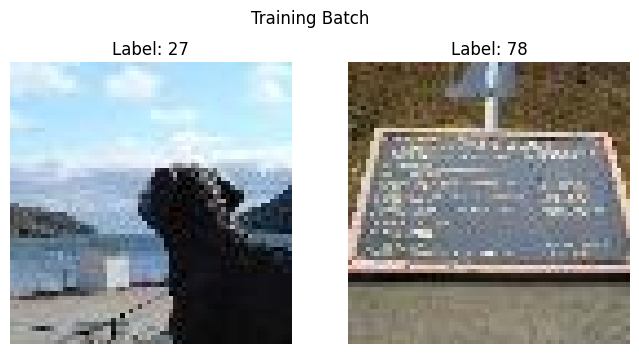

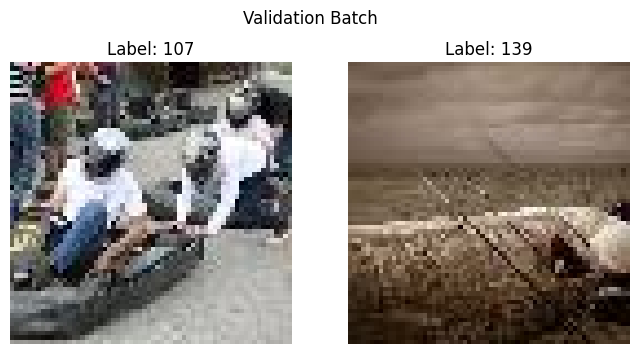

In [11]:

# Define the AViT_DataModule.
data_module = AViT_DataModule(
    train_data_dir="/kaggle/input/tiny-imagenet/tiny-imagenet-200/train/",
    val_data_dir="/kaggle/input/tiny-imagenet/tiny-imagenet-200/val/images/",
    batch_size=512  
)

# Setup the Dataloaders.
data_module.setup()

# Get a batch from the Training DataLoader.
train_dataloader = data_module.train_dataloader()
train_batch = next(iter(train_dataloader))

# Get a batch from the Validation DataLoader.
val_dataloader = data_module.val_dataloader()
val_batch = next(iter(val_dataloader))

# Show two Images from the Training Batch.
show_images_labels(train_batch[0][:2], train_batch[1][:2], title='Training Batch')

# Show two Images from the  Validation Batch
show_images_labels(val_batch[0][:2], val_batch[1][:2], title='Validation Batch')

### 3: MODEL DEFINITION

#### 3.0: PATCHING FUNCTION DEFINITION

In [12]:

def Make_Patches_from_Image(images, n_patches):
    """
    Extract patches from input images.

    Parameters:
    - images (torch.Tensor): Input images tensor with shape (batch_size, channels, height, width).
    - n_patches (int): Number of patches in each dimension.

    Returns:
    torch.Tensor: Extracted patches tensor with shape (batch_size, n_patches^2, patch_size^2 * channels).
    """
    # Get the dimensions of the input images.
    n, c, h, w = images.shape

    # Ensure that the input images are square.
    assert h == w, "make_patches_from_image method is implemented for square images only!"

    # Initialize a tensor to store the extracted patches.
    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    # Loop over each image in the batch.
    for idx, image in enumerate(images):
        # Loop over each patch in both dimensions.
        for i in range(n_patches):
            for j in range(n_patches):
                # Extract the patch from the image.
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                # Flatten the patch and store it in the patches tensor.
                patches[idx, i * n_patches + j] = patch.flatten()

    return patches


In [13]:

# Helper function to Visualize Patches.
def visualize_patches(images, n_patches, title):
    """
    Visualize patches extracted from Images.

    Parameters:
    - images (torch.Tensor): Input images tensor with shape (batch_size, channels, height, width).
    - n_patches (int): Number of patches in each dimension.
    - title (str): Title for the entire subplot.

    Returns:
    None
    """
    # Extract patches from the input images using the make_patches_from_image function.
    patches = Make_Patches_from_Image(images, n_patches)
    
    # Create a subplot for visualizing patches.
    fig, axs = plt.subplots(n_patches, n_patches, figsize=(8, 8))
    fig.suptitle(title)
    
    # Calculate the patch size based on the input images.
    patch_size = images.shape[-1] // n_patches

    # Loop over each patch in both dimensions.
    for i in range(n_patches):
        for j in range(n_patches):
            # Calculate the index of the patch.
            patch_index = i * n_patches + j
            # Reshape each patch to (3, patch_size, patch_size).
            patch = patches[0, patch_index].reshape(3, patch_size, patch_size).cpu().numpy()
            # Display the patch in the subplot.
            axs[i, j].imshow(patch.transpose(1, 2, 0))
            axs[i, j].axis('off')

    # Show the entire subplot.
    plt.show()


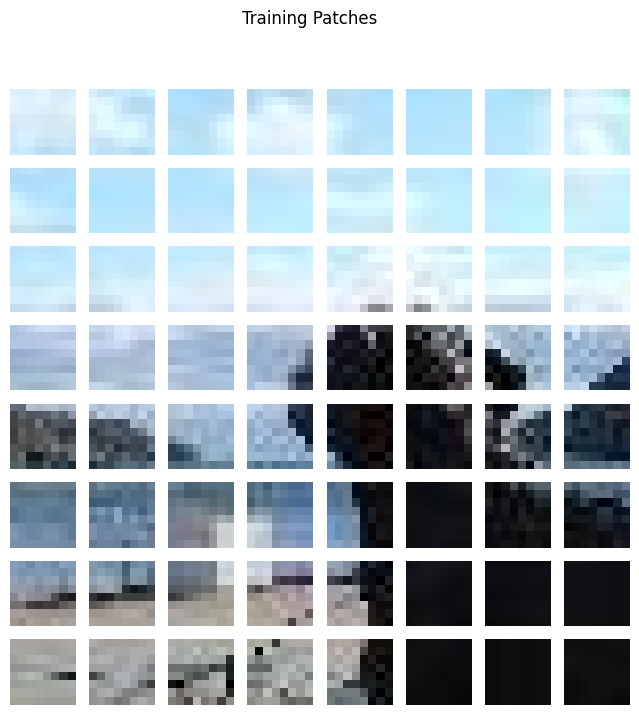

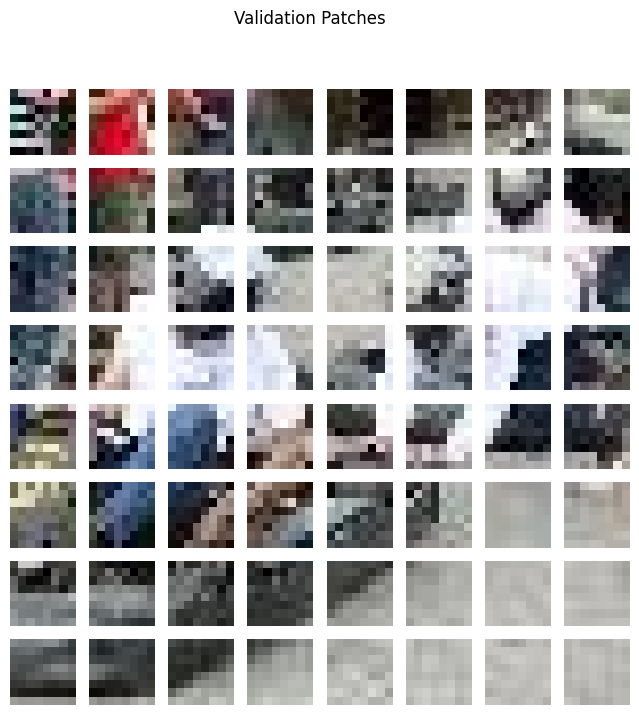

In [14]:
# Visualize patches for a Training Image.
visualize_patches(train_batch[0], n_patches=8, title='Training Patches')

# Visualize patches for a Validation Image
visualize_patches(val_batch[0], n_patches=8, title='Validation Patches')

#### 3.1: POSITIONAL EMBEDDING DEFINITION

In [15]:
def get_positional_embeddings_Basic(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result


##### 3.1.1: SINUSOIDAL POSITIONAL ENCODING (SPE)



In [16]:

def get_positional_embeddings_SPE(sequence_length, d):
    """
    Generate Positional Embeddings for the Transformer Model.

    Parameters:
    - sequence_length (int): Length of the input sequence.
    - d (int): Dimension of the embeddings.

    Returns:
    torch.Tensor: Positional Embeddings tensor of shape (sequence_length, d).
    """
    # Generate a tensor of positions from 0 to sequence_length - 1.
    positions = torch.arange(0, sequence_length).float().view(-1, 1)
    
    # Calculate div_term for both sin and cos terms.
    div_term = torch.exp(torch.arange(0, d, 2).float() * -(np.log(10000.0) / d))

    # Initialize the embeddings tensor with zeros.
    embeddings = torch.zeros(sequence_length, d)
    
    # Compute sin and cos terms and assign them to the embeddings tensor.
    embeddings[:, 0::2] = torch.sin(positions / div_term)
    embeddings[:, 1::2] = torch.cos(positions / div_term)

    return embeddings

##### 3.1.2: LAYER-ADAPTIVE POSITIONAL EMBEDDING (LaPE)

In [17]:

def get_positional_embeddings_LaPE(sequence_length, d, num_layers):
    """
    Generate Layer-adaptive Positional Embeddings for the Transformer Model.

    Parameters:
    - sequence_length (int): Length of the input sequence.
    - d (int): Dimension of the embeddings.
    - num_layers (int): Number of layers in the Transformer model.

    Returns:
    torch.Tensor: Layer-adaptive Positional Embeddings tensor of shape (sequence_length, d, num_layers).
    """
    # Generate a tensor of positions from 0 to sequence_length - 1.
    positions = torch.arange(0, sequence_length).float().view(-1, 1)

    # Precompute div_terms for each layer.
    div_terms = torch.exp(torch.arange(0, d, 2).float() * -(np.log(10000.0) / d))

    # Initialize the embeddings tensor with zeros.
    embeddings = torch.zeros(sequence_length, d, num_layers)

    # Divide the sequence_length by 2 once for efficiency.
    seq_len_div_2 = sequence_length // 2

    # Compute sin and cos terms for each layer and assign them to the embeddings tensor.
    for layer in range(num_layers):
        embeddings[:, :, layer][:, 0:seq_len_div_2] = torch.sin(positions / div_terms[layer])
        embeddings[:, :, layer][:, seq_len_div_2:] = torch.cos(positions / div_terms[layer])

    return embeddings


##### 3.1.2.1: IMAGE POSITIONAL EMBEDDINGS.

##### 3.1.3: VISUALIZE POSITIONAL EMBEDDINGS

In [18]:

# Helper function to Visualize Positional Embeddings.
def visualize_positional_embeddings(embeddings):
    """
    Visualize the Positional Embeddings.

    Parameters:
    - embeddings (torch.Tensor): Positional embeddings tensor.

    Returns:
    None
    """
    
    # Get the number of dimensions (d) from the Embeddings Tensor.
    d = embeddings.size(1)

    # Set the figure size for a larger image.
    plt.figure(figsize=(12, 6))

    # Plot each dimension separately.
    for i in range(d):
        plt.plot(embeddings[:, i].numpy(), label=f'Dimension {i}')

    # Set plot labels.
    plt.xlabel('Position')
    plt.ylabel('Embedding Value')
    plt.title('Visualization of Positional Embeddings')

    # Place the legend on the right and diminish its size.
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
    
    # Show the plot.
    plt.show()


In [19]:
# Helper function to Visualize Positional Embeddings as a Heatmap.
def visualize_positional_embeddings_heatmap(embeddings):
    """
    Visualize the Positional Embeddings as a Heatmap.

    Parameters:
    - embeddings (torch.Tensor): Positional embeddings tensor.

    Returns:
    None
    """
    
    # Get the number of dimensions (d) from the Embeddings Tensor.
    d = embeddings.size(1)

    # Set the figure size for a larger image.
    plt.figure(figsize=(12, 6))

    # Create a heatmap for the positional embeddings.
    sns.heatmap(embeddings.T.numpy(), cmap='viridis', cbar_kws={'label': 'Embedding Value'})

    # Set plot labels and title.
    plt.xlabel('Position')
    plt.ylabel('Dimension')
    plt.title('Visualization of Positional Embeddings (Heatmap)')
    
    # Show the plot.
    plt.show()


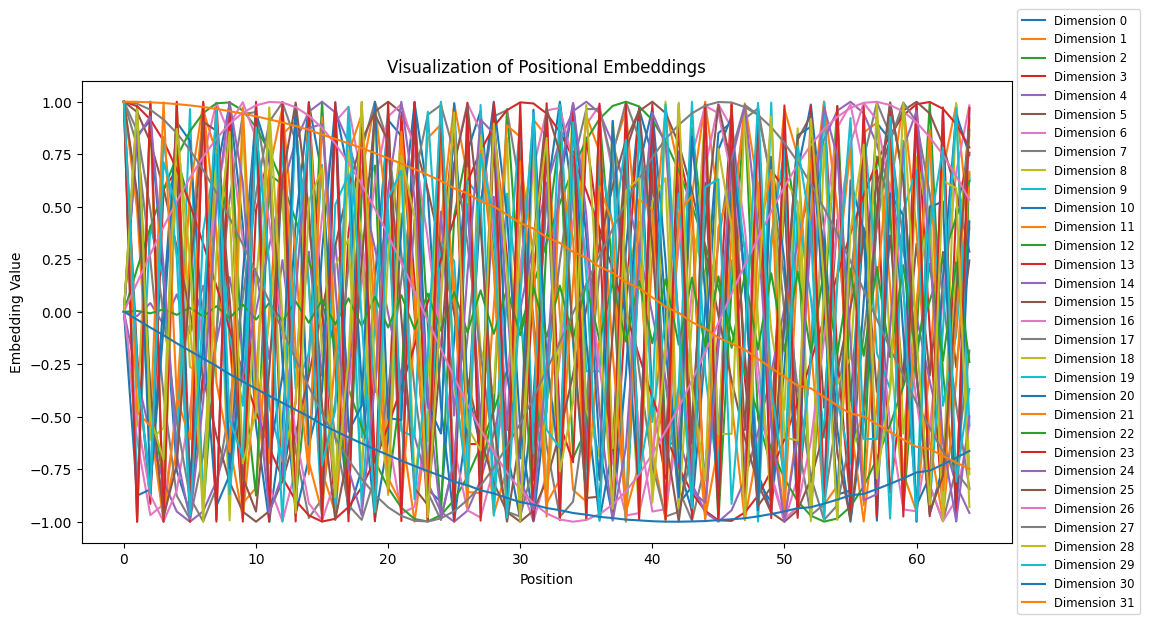

In [20]:
positional_embeddings = get_positional_embeddings_SPE(65, 32)
visualize_positional_embeddings(positional_embeddings)

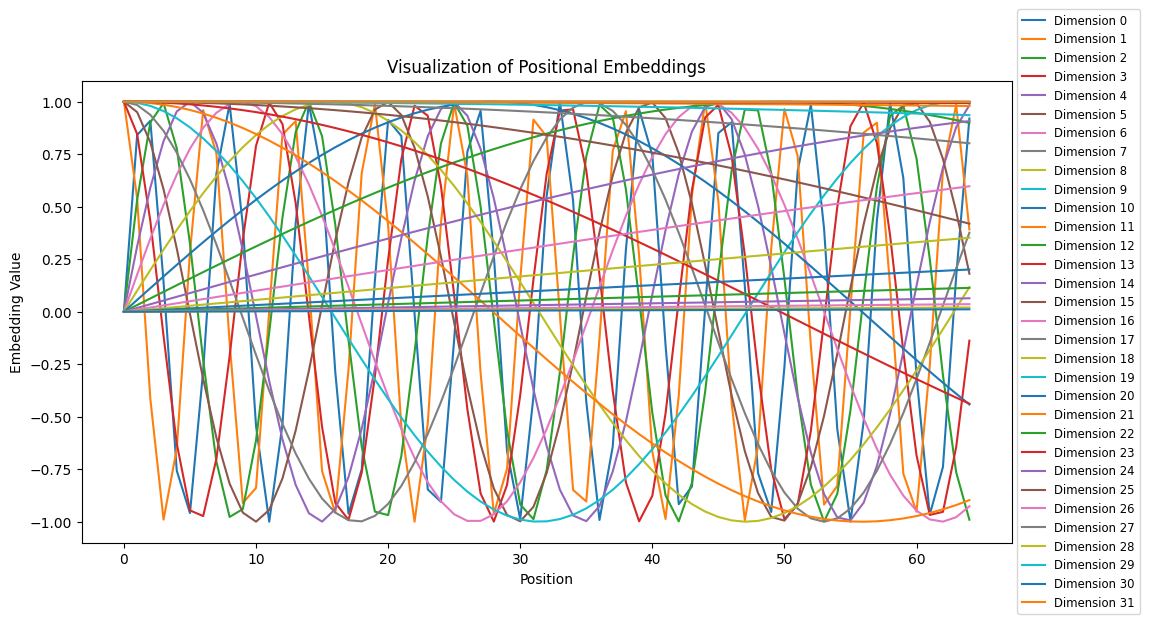

In [21]:
positional_embeddings = get_positional_embeddings_Basic(65, 32)
visualize_positional_embeddings(positional_embeddings)

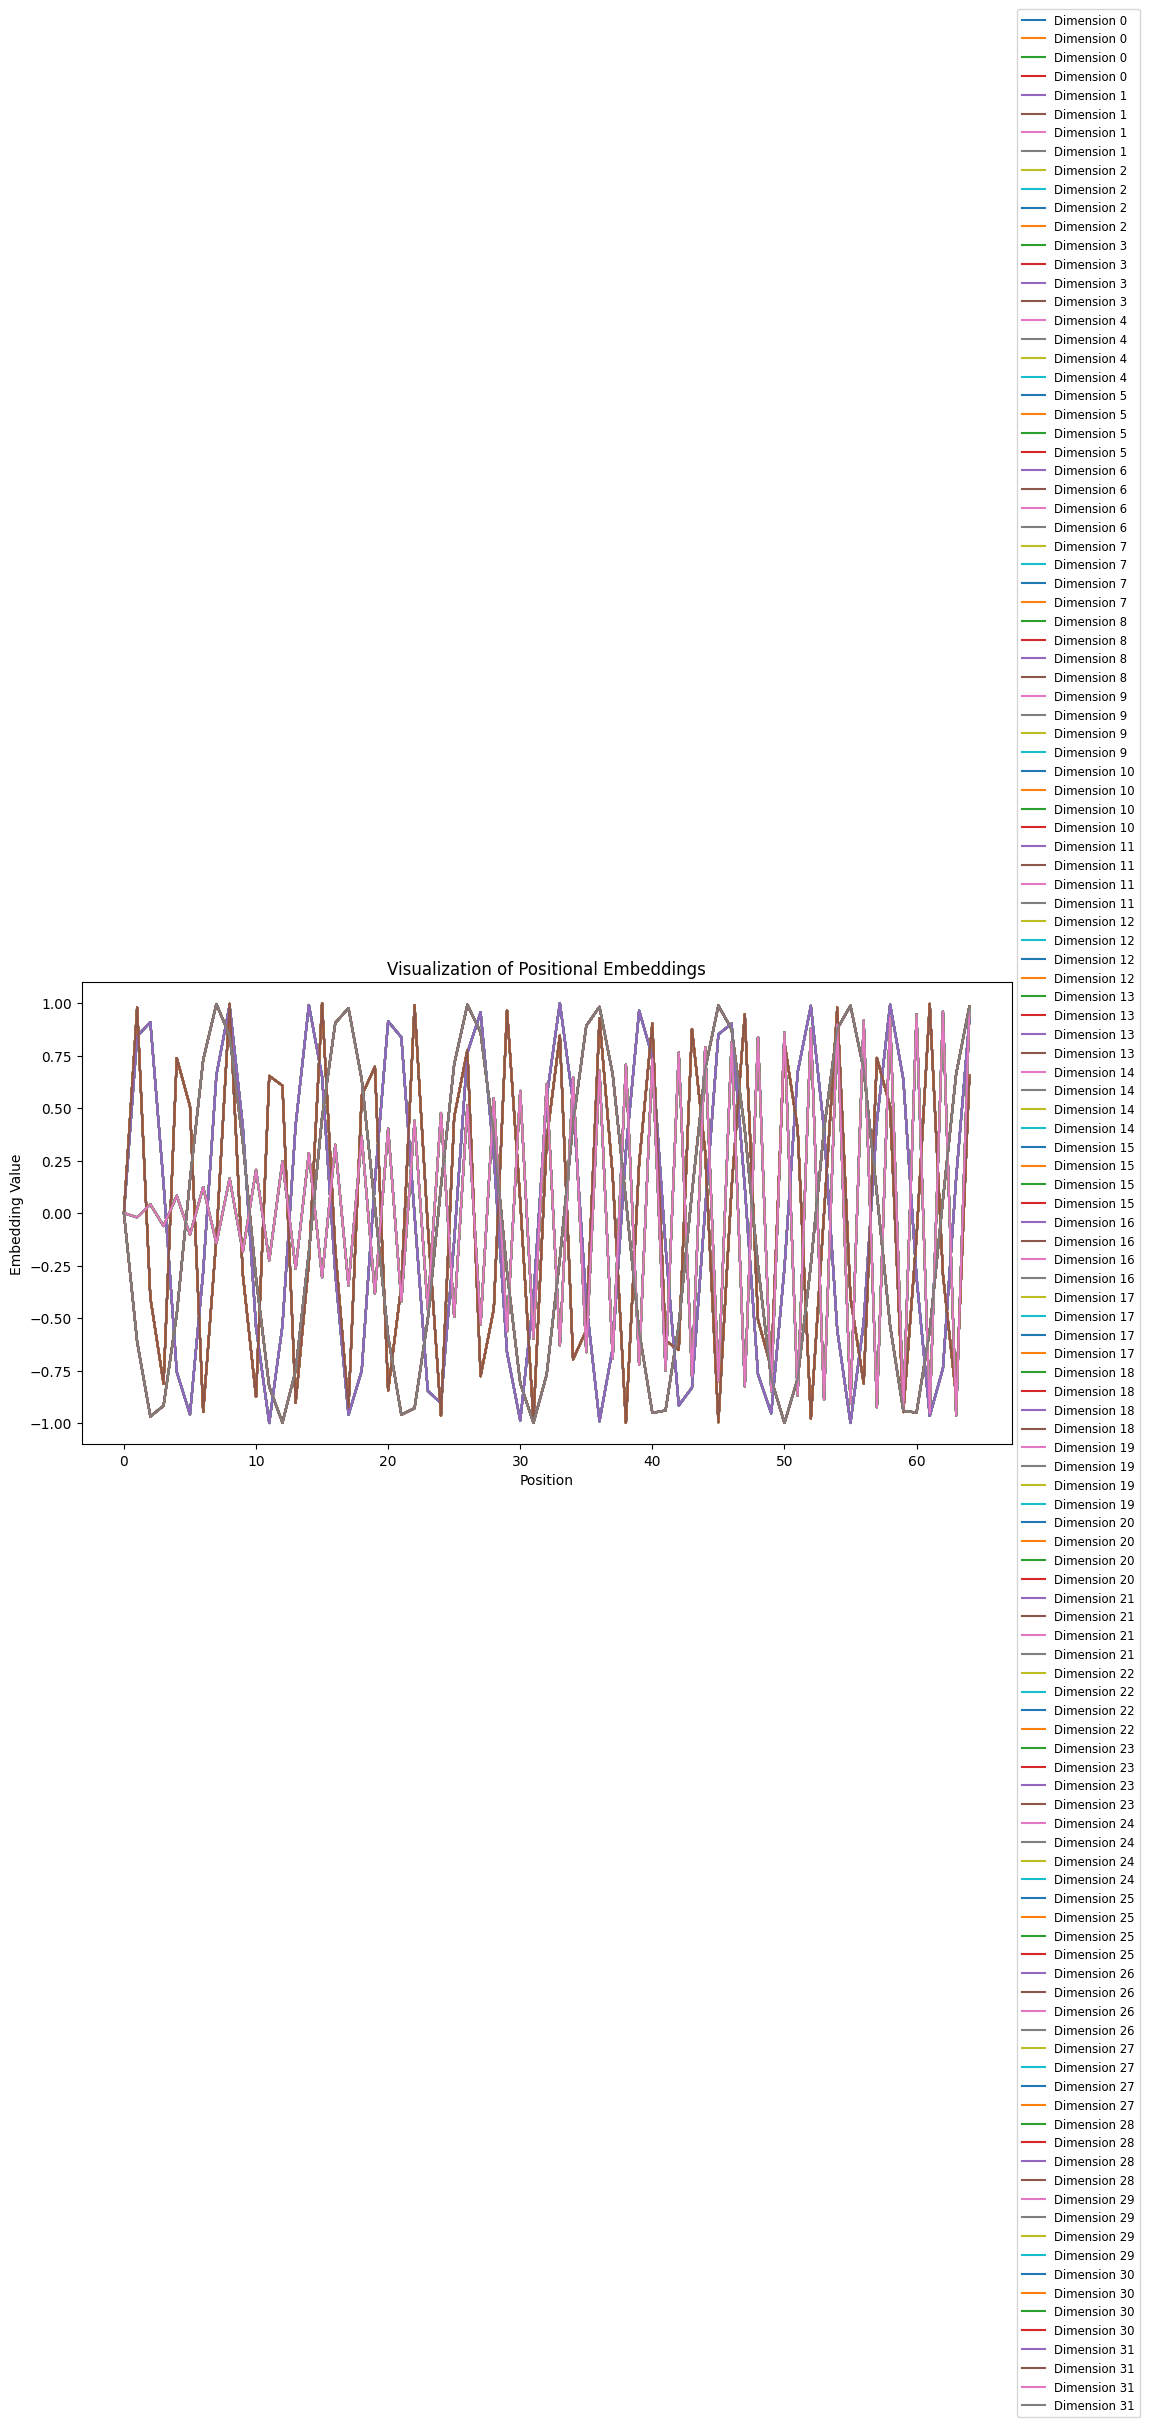

In [22]:
positional_embeddings = get_positional_embeddings_LaPE(65, 32, 4)
visualize_positional_embeddings(positional_embeddings)

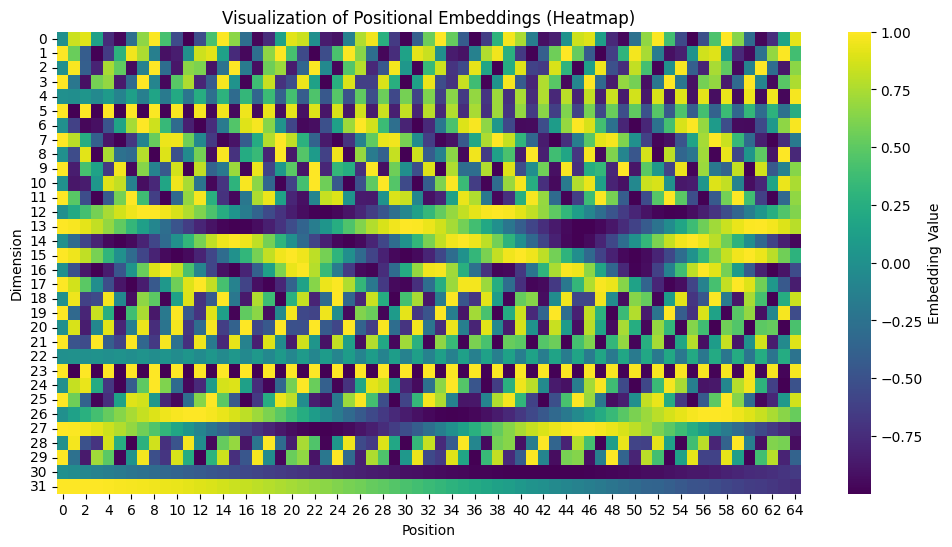

In [23]:
positional_embeddings = get_positional_embeddings_SPE(65, 32)
visualize_positional_embeddings_heatmap(positional_embeddings)

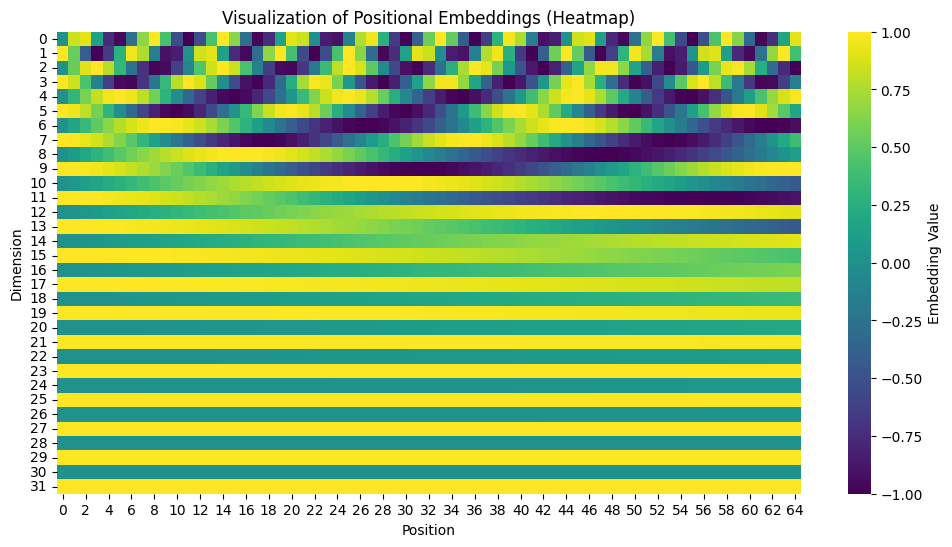

In [24]:
positional_embeddings = get_positional_embeddings_Basic(65, 32)
visualize_positional_embeddings_heatmap(positional_embeddings)

#### 3.2: MULTI-HEAD SELF-ATTENTION DEFINITION

In [25]:

class MyMHSA(nn.Module):
    
    def __init__(self, d, n_heads=2):
        """
        Multi-Head Self Attention (MHSA) Module.

        Parameters:
        - d (int): Dimension of the input tokens.
        - n_heads (int): Number of attention heads.

        Returns:
        None
        """
        
        super(MyMHSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        # Split the dimension into n_heads parts.
        d_head = int(d / n_heads)
        
        # Linear mappings for Query(q), Key(k), and Value(v) for each head.
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)
        
        # Initialize weights.
        self.initialize_weights_msa()
        
    def forward(self, sequences):
        """
        Forward pass of the MHSA module.

        Parameters:
        - sequences (torch.Tensor): Input token sequences with shape (N, seq_length, token_dim).

        Returns:
        torch.Tensor: Output tensor after MHSA with shape (N, seq_length, item_dim).
        """
        
        result = []
        for sequence in sequences:
            
            seq_result = []
            for head in range(self.n_heads):
                
                # Compute the q,k,v for every head. 
                q_mapping, k_mapping, v_mapping = self.q_mappings[head], self.k_mappings[head], self.v_mappings[head]

                # Extract the corresponding part of the sequence for the current head.
                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                # Calculate attention scores and apply softmax.
                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            
            # Concatenate the results coming from the different Heads and Stack Vertically the result.
            result.append(torch.hstack(seq_result))
        
        # Concatenate results for all the sequences.
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])
    
    def initialize_weights_msa(self):
        """
        Initialize weights for linear layers in the MHSA module.

        Parameters:
        None

        Returns:
        None
        """
        
        # Initialize weights for the q, k, v values.
        for q_mapping, k_mapping, v_mapping in zip(self.q_mappings, self.k_mappings, self.v_mappings):
            nn.init.xavier_uniform_(q_mapping.weight)
            nn.init.xavier_uniform_(k_mapping.weight)
            nn.init.xavier_uniform_(v_mapping.weight)


#### 3.3: ViT BLOCK DEFINITION

In [26]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=10):
        super(MyViTBlock, self).__init__()
        
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMHSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )
        
        # Initialize weights.
        self.initialize_weights_block()

    def forward(self, x):
        
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out
    
    def initialize_weights_block(self):
        
        # Initialize weights for linear layers in mlp.
        for layer in self.mlp:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)

#### 3.4: ViT MODEL DEFINITION

##### 3.4.1: TARGET DISTRIBUTIONAL PRIOR DEFINITION

Note that layer depth goes from 0 to n_layers -1 .

In [27]:

def get_distribution_target(n_layers=4, exp_stop_depth=1):
    """
    Generate the Target Distributional Prior.

    Parameters:
    - n_layers (int): Length of the distribution(number of transformers blocks or layers).
    - exp_stop_depth (int): Depth of the target distribution(expected stopping depth).

    Returns:
    numpy.ndarray: Target distributional prior.
    """
    
    # Generate a series of values from 0 to length - 1.
    data = np.arange(n_layers)
    
    # Generate a Gausian Normal Distribution centered around target_depth.
    data = norm.pdf(data, loc=exp_stop_depth, scale=1)
    
    # Scale the distribution to have a maximum value of 1.
    scaling_factor = (0.98) / sum(data[:exp_stop_depth])
    data *= scaling_factor

    return data

##### 3.4.2: MYVIT CLASS DEFINITION

In [28]:

class MyViT(nn.Module):
        
    def __init__(self, chw, n_patches, n_blocks, hidden_d, n_heads, out_d):
        """
        Initialize the MyViT model.

        Parameters:
        - chw (tuple): Input shape (C, H, W).
        - n_patches (int): Number of patches.
        - n_blocks (int): Number of transformer blocks.
        - hidden_d (int): Dimension of the hidden layer.
        - n_heads (int): Number of attention heads.
        - out_d (int): Output dimension.
        """
        
        # Super Constructor.
        super(MyViT, self).__init__()
        
        # Attributes.
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        self.mlp_ratio = 50
        
        # Halting Prior Distribution Loss and Target Distribution.
        self.ponder_loss = 0
        self.distr_prior_loss = 0
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')
        self.distr_target = torch.Tensor(get_distribution_target())
        self.num_halted_layers = [[0,1e-10,1e10,0] for _ in range(self.n_blocks)]# for each layer we have a 4 values, List[0] = sum of halted tokens, List[1]= Max ,List[2] = Min, List[3] = Variance
        
        # Input and Patches Sizes.
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear Mapper.
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable Classification Token.
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Positional Embedding.
        self.register_buffer('positional_embeddings', get_positional_embeddings_SPE(n_patches ** 2 + 1, self.hidden_d), persistent=False)
        
        # 4) Transformer Encoder Blocks.
        self.blocks = nn.ModuleList([MyViTBlock(self.hidden_d, self.n_heads) for _ in range(self.n_blocks)])
        
        # 5) Classification MLP.
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, self.mlp_ratio * self.hidden_d),
            nn.GELU(),
            nn.Linear(self.mlp_ratio * self.hidden_d, out_d),
            nn.LogSoftmax(dim=-1)
        )
        
        # Initialize weights.
        self.initialize_weights()

    def forward(self, images):
        """
        Forward pass of the MyViT model.

        Parameters:
        - images (torch.Tensor): Input images tensor.

        Returns:
        torch.Tensor: Output tensor.
        """
        
        # Dividing Images into Patches.
        n, c, h, w = images.shape
        patches = Make_Patches_from_Image(images, self.n_patches).to(self.positional_embeddings.device)
        
        # Running Linear Layer Tokenization.
        # Map the Vector corresponding to each patch to the Hidden Size Dimension.
        tokens = self.linear_mapper(patches)
        
        # Adding Classification Token to the Tokens.
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        
        # Adding Positional Embedding.
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        ### Halting Procedure ###
        total_token_count=len(out[1]) # out.shape = [512,65,32]
        batch_size = out.size()[0]  # The batch size
        cumul_token = torch.zeros(batch_size,total_token_count)
        r = torch.ones(batch_size,total_token_count)
        rho = torch.zeros(batch_size,total_token_count)
        mask = torch.ones(batch_size,total_token_count)
        
        # Halting Hyperparameters.
        gamma = 5
        beta = -10
        alpha_p = 5e-4
        alpha_d = 0.1
        eps = 0.5
        threshold = 1 - eps
        output = None  # Final output of Adaptive Vision Transformer Block.
        halting_score_list=[] # List of Layer Halting Score Average.

        
        # Transformer Blocks.
        for i,block in enumerate(self.blocks):
            #512images each with 65 tokens -> total number of tokens per batch = 512 * 65 = 33280
            #%halted_tokens per batch= number_of halted token / total number of token = 
            
            # Previous Layers Token are masked.
            out.data = out.data * mask.float().view(batch_size,total_token_count, 1)
            
            # Pass data trough each layer(block).
            out = block(out.data) #out.shape = [512,65,32]
            
            # Compute Halting Scores.                 
            t_0 = out[:,:,0] #out[:,:,0] = contains all the halting scores of images tokens ( t_O.shape = [512,65])
            h_score = torch.sigmoid(gamma*t_0 + beta)
           
            # Update list with mean of halting score just computed.
            halting_score_list.append(torch.mean(h_score[1:])) 
            
            # Set all token halting score to one if we reached last layer(block).
            if i == len(self.blocks)-1:
                h_score = torch.ones(batch_size,total_token_count) 
                
            # Last Layer Protection.
            out = out *  mask.float().view(batch_size,total_token_count, 1) #out.shape = [512,65,32]
            
            # Update Accumulator.
            cumul_token = cumul_token + h_score #cumul_token.shape = [512,65]
            
            #update rho.
            rho = rho + mask.float() #rho.shape = [512,65]
        
            # Case 1: Threshold reached in this Iteration.
            halted_token = cumul_token > threshold #shape [512,65]
            num_halted = torch.sum(halted_token) #number of halted token at layer i per batch
            self.num_halted_layers[i][0] += num_halted
            if num_halted > self.num_halted_layers[i][1]:
                self.num_halted_layers[i][1] = num_halted
            if num_halted < self.num_halted_layers[i][2]:
                self.num_halted_layers[i][2] = num_halted
            halted_token = halted_token.float() * mask.float()  #shape [512,65]
            out1 = out * r.view(batch_size, total_token_count, 1) * halted_token.view(batch_size, total_token_count, 1) # [512,65,32] * [512,65,1] * [512,65,1]
            rho = rho + (r * halted_token)  #shape [512,65]

            # Case 2: Threshold not reached.
            not_halted_token = cumul_token < threshold
            not_halted_token = not_halted_token.float()
            r = r - (not_halted_token.float() * h_score)
            out2 = out * h_score.view(batch_size, total_token_count, 1) * not_halted_token.view(batch_size, total_token_count, 1)
            
            # Update the mask.
            mask = cumul_token < threshold
            
            if output is None:
                output = out1 + out2
            else:
                output = output + (out1 + out2)
                
        # Halting Prior Distribution.
        halting_distribution = torch.stack(halting_score_list)
        halting_distribution /= torch.sum(halting_distribution)
        halting_distribution = torch.clamp(halting_distribution, 0.01, 0.99) 
        
        # Kullback-Leibler Divergence. 
        self.distr_prior_loss = alpha_d * self.kl_loss(halting_distribution, self.distr_target)
        
        # Ponder Loss.
        self.ponder_loss = alpha_p * torch.mean(rho)
        
        # Getting the Classification Token only.
        output = output[:, 0] #shape=[512,32]
        
        return self.mlp(output) # Map to output dimension (classification head).
    

    def initialize_weights(self):
        """
        Initialize weights for linear layers, embeddings, etc.
        """
        
        # Initialize Weights for Linear Layers, Embeddings, etc.
        nn.init.xavier_uniform_(self.linear_mapper.weight)
        nn.init.normal_(self.class_token.data)

        # Initialize Weights for Classification MLP.
        nn.init.xavier_uniform_(self.mlp[0].weight)
    

#### 3.5: GENERAL AViT MODEL DEFINITION

In [29]:

class AViT_Model(MyViT, pl.LightningModule):
    
    def __init__(self, input_d, n_patches, n_blocks, hidden_d, n_heads, out_d):
        """
        Initialize the AViT_Model, a LightningModule using MyViT as a base.

        Parameters:
        - input_d (int): Dimension of the input.
        - n_patches (int): Number of patches.
        - n_blocks (int): Number of transformer blocks.
        - hidden_d (int): Dimension of the hidden layer.
        - n_heads (int): Number of attention heads.
        - out_d (int): Output dimension.
        """
        super(AViT_Model, self).__init__(input_d, n_patches, n_blocks, hidden_d, n_heads, out_d)

        # Definition of the Cross Entropy Loss.
        self.loss = CrossEntropyLoss()

        # Definition of Accuracies, F1Score, Precision, and Recall Metrics.
        self.acc_top1 = Accuracy(task="multiclass", num_classes=out_d)
        self.acc_top3 = Accuracy(task="multiclass", num_classes=out_d, top_k=3)
        self.acc_top5 = Accuracy(task="multiclass", num_classes=out_d, top_k=5)
        self.acc_top10 = Accuracy(task="multiclass", num_classes=out_d, top_k=10)
        self.f1score = MulticlassF1Score(num_classes=out_d, average='macro')
        self.precision = MulticlassPrecision(num_classes=out_d, average='macro')
        self.recall = MulticlassRecall(num_classes=out_d, average='macro')

        # Definition of lists to be used in the "on_ ... _epoch_end" functions.
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def _step(self, batch):
        """
        Common computation of the metrics among Training, Validation, and Test Set.

        Parameters:
        - batch (tuple): Input batch tuple.

        Returns:
        tuple: Tuple containing loss and various metrics.
        """
        x, y = batch
        preds = self(x)
        loss = self.loss(preds, y) + self.ponder_loss + self.distr_prior_loss
        acc1 = self.acc_top1(preds, y)
        acc3 = self.acc_top3(preds, y)
        acc5 = self.acc_top5(preds, y)
        acc10 = self.acc_top10(preds, y)
        f1score = self.f1score(preds, y)
        precision = self.precision(preds, y)
        recall = self.recall(preds, y)

        return loss, acc1, acc3, acc5, acc10, f1score, precision, recall

    def training_step(self, batch, batch_idx):
        """
        Training step function.

        Parameters:
        - batch (tuple): Input batch tuple.
        - batch_idx (int): Batch index.

        Returns:
        torch.Tensor: Training loss.
        """
        # Compute the Training Loss and Accuracy.
        loss, acc, _, _, _, _, _, _ = self._step(batch)

        # Create a Dictionary to represent the output of the Training step.
        training_step_output = {
            "train_loss": loss.item(),
            "train_acc": acc.item()
        }

        # Append the dictionary to the list.
        self.training_step_outputs.append(training_step_output)

        # Perform logging.
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
    
    def on_training_epoch_end(self):
        """
        Method called at the end of the training epoch.

        Returns:
        None
        """
        total_token_dataset = 1e+5 * (self.n_patches ** 2 + 1)
        print("Count",total_token_dataset)
        mean_halted_token = [i[0]/total_token_dataset for i in self.num_halted_layers]
        variance_halted_token = [i[1] - i[2] for i in self.num_halted_layers]
        max_halted_token = [i[1] for i in self.num_halted_layers] #per batch
        min_halted_token = [i[1] for i in self.num_halted_layers] #per batch
        print(f"Mean: {mean_halted_token} Max: {max_halted_token} Min: {min_halted_token} Variance: {variance_halted_token}")
        # Log the  halting values.
        self.log("mean_halted_token", mean_halted_token)
        self.log("variance_halted_token", variance_halted_token)
        self.log("max_halted_token", max_halted_token)
        self.log("min_halted_token", min_halted_token)
        
        

    def validation_step(self, batch, batch_idx):
        """
        Validation step function.

        Parameters:
        - batch (tuple): Input batch tuple.
        - batch_idx (int): Batch index.

        Returns:
        None
        """
        # Compute the Validation Loss and Accuracy.
        loss, acc1, acc3, acc5, acc10, _, _, _ = self._step(batch)

        # Create a Dictionary to represent the output of the validation step.
        validation_step_output = {
            "val_loss": loss.item(),
            "val_acc": acc1.item(),
            "val_acc_3": acc3.item(),
            "val_acc_5": acc5.item(),
            "val_acc_10": acc10.item(),
        }

        # Append the dictionary to the list.
        self.validation_step_outputs.append(validation_step_output)

        # Perform logging.
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", acc1, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc_3", acc3, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc_5", acc5, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc_10", acc10, on_epoch=True, prog_bar=True, logger=True)

    def on_validation_epoch_end(self):
        """
        Method called at the end of the validation epoch.

        Returns:
        None
        """
        # Calculate the Mean Loss and Accuracy from the list of dictionaries.
        loss_tot = torch.tensor([item["val_loss"] for item in self.validation_step_outputs]).mean()
        acc_tot = torch.tensor([item["val_acc"] for item in self.validation_step_outputs]).mean()
        acc_tot_3 = torch.tensor([item["val_acc_3"] for item in self.validation_step_outputs]).mean()
        acc_tot_5 = torch.tensor([item["val_acc_5"] for item in self.validation_step_outputs]).mean()
        acc_tot_10 = torch.tensor([item["val_acc_10"] for item in self.validation_step_outputs]).mean()

        # Log the mean values.
        self.log("val_loss", loss_tot)
        self.log("val_acc", acc_tot)
        self.log("val_acc_3", acc_tot_3)
        self.log("val_acc_5", acc_tot_5)
        self.log("val_acc_10", acc_tot_10)

        # Print messages.
        message_loss = f'Epoch {self.current_epoch} Validation Loss -> {loss_tot}'
        message_accuracy = f'      Validation Accuracy -> {acc_tot}'
        message_accuracy_3 = f'      Validation Accuracy Top-3 -> {acc_tot_3}'
        message_accuracy_5 = f'      Validation Accuracy Top-5-> {acc_tot_5}'
        message_accuracy_10 = f'      Validation Accuracy Top-10-> {acc_tot_10}'
        print(message_loss + message_accuracy + message_accuracy_3 + message_accuracy_5 + message_accuracy_10)

        # Clear the list to free memory.
        self.validation_step_outputs.clear()


    def configure_optimizers(self):
        """
        Configure the optimizer.

        Returns:
        torch.optim.Optimizer: The optimizer.
        """
        # Configure the Adam Optimizer.
        optimizer = optim.Adam(self.parameters(), lr=1.5e-3, weight_decay=1.5e-4)

        # Configure the Cosine Annealing Learning Rate Scheduler.
        # scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=1.5e-6)

        # return {"optimizer": optimizer, "lr_scheduler": scheduler}
        return optimizer


### 4: MODEL TRAINING

#### 4.1: CALLBACKS DEFINITION

In [30]:
# Checkpoint CallBack Definition.
my_checkpoint_call = ModelCheckpoint(
    dirpath="/kaggle/working/checkpoints/",
    filename="Best_Model",
    monitor="val_acc",
    mode="min",
    save_top_k=1,
    save_last=True
)

# Learning Rate CallBack Definition.
my_lr_monitor_call = LearningRateMonitor(logging_interval="epoch")

# Early Stopping CallBack Definition.
my_early_stopping_call = pl.callbacks.EarlyStopping(monitor="val_loss", patience=30, mode="min", min_delta=0.001)

# Progress Bar CallBack Definition.
my_progress_bar_call = TQDMProgressBar(refresh_rate=10)

# TensorBoardLogger CallBack Definition.
tb_logger = TensorBoardLogger(save_dir="/kaggle/working/logs", name="AViT")

# CSV CallBack Definition.
csv_logger = CSVLogger("/kaggle/working/logs", name="AViT")


#### 4.2: MODEL INSTANTIATION & TRAINING

In [31]:

# Instantiate the Adaptive Vision Transformer Model.
model = AViT_Model((3, 64, 64), 
                   n_patches=8, 
                   n_blocks=4, 
                   hidden_d=32, 
                   n_heads=4, 
                   out_d = 200)

datamodule = AViT_DataModule(train_data_dir="/kaggle/input/tiny-imagenet/tiny-imagenet-200/train/", 
                             val_data_dir="/kaggle/input/tiny-imagenet/tiny-imagenet-200/val/images/", 
                             batch_size=512)

# Setup the Dataloaders. 
data_module.setup()

# Create a PyTorch Lightning Trainer.
trainer = pl.Trainer(
    max_epochs=25,
    accelerator="auto", 
    devices="auto",
    log_every_n_steps=1,
    logger=tb_logger,
    callbacks=[my_progress_bar_call,
               my_checkpoint_call,
               my_lr_monitor_call,
               my_early_stopping_call,
               ]
)


In [32]:
# Train the model
trainer.fit(model, datamodule)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0 Validation Loss -> 5.279432773590088      Validation Accuracy -> 0.0      Validation Accuracy Top-3 -> 0.0087890625      Validation Accuracy Top-5-> 0.015625      Validation Accuracy Top-10-> 0.0478515625


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0 Validation Loss -> 4.909369468688965      Validation Accuracy -> 0.03336971253156662      Validation Accuracy Top-3 -> 0.07821691036224365      Validation Accuracy Top-5-> 0.11721622943878174      Validation Accuracy Top-10-> 0.19352595508098602


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 Validation Loss -> 4.842072486877441      Validation Accuracy -> 0.0390625      Validation Accuracy Top-3 -> 0.09233685582876205      Validation Accuracy Top-5-> 0.1339326798915863      Validation Accuracy Top-10-> 0.21281595528125763


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2 Validation Loss -> 4.784811496734619      Validation Accuracy -> 0.040929459035396576      Validation Accuracy Top-3 -> 0.10210248082876205      Validation Accuracy Top-5-> 0.1538717895746231      Validation Accuracy Top-10-> 0.24284236133098602


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3 Validation Loss -> 4.747696876525879      Validation Accuracy -> 0.04982766509056091      Validation Accuracy Top-3 -> 0.11233341693878174      Validation Accuracy Top-5-> 0.161173015832901      Validation Accuracy Top-10-> 0.24512293934822083


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4 Validation Loss -> 4.726248741149902      Validation Accuracy -> 0.04977022111415863      Validation Accuracy Top-3 -> 0.11494715511798859      Validation Accuracy Top-5-> 0.16264936327934265      Validation Accuracy Top-10-> 0.2561810612678528


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5 Validation Loss -> 4.690363883972168      Validation Accuracy -> 0.05550896003842354      Validation Accuracy Top-3 -> 0.12467256933450699      Validation Accuracy Top-5-> 0.17359834909439087      Validation Accuracy Top-10-> 0.272012859582901


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6 Validation Loss -> 4.674026966094971      Validation Accuracy -> 0.05537109449505806      Validation Accuracy Top-3 -> 0.1253446638584137      Validation Accuracy Top-5-> 0.17788372933864594      Validation Accuracy Top-10-> 0.2725183963775635


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7 Validation Loss -> 4.666436672210693      Validation Accuracy -> 0.05823184922337532      Validation Accuracy Top-3 -> 0.12928538024425507      Validation Accuracy Top-5-> 0.184610515832901      Validation Accuracy Top-10-> 0.2803940773010254


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8 Validation Loss -> 4.661442756652832      Validation Accuracy -> 0.056640625      Validation Accuracy Top-3 -> 0.12914177775382996      Validation Accuracy Top-5-> 0.18226677179336548      Validation Accuracy Top-10-> 0.2790153920650482


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9 Validation Loss -> 4.645127773284912      Validation Accuracy -> 0.057531021535396576      Validation Accuracy Top-3 -> 0.1315889209508896      Validation Accuracy Top-5-> 0.1840016096830368      Validation Accuracy Top-10-> 0.2852137088775635


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10 Validation Loss -> 4.645011901855469      Validation Accuracy -> 0.058995865285396576      Validation Accuracy Top-3 -> 0.1330365389585495      Validation Accuracy Top-5-> 0.18952205777168274      Validation Accuracy Top-10-> 0.282186359167099


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11 Validation Loss -> 4.643954277038574      Validation Accuracy -> 0.060167741030454636      Validation Accuracy Top-3 -> 0.1304342895746231      Validation Accuracy Top-5-> 0.1853630542755127      Validation Accuracy Top-10-> 0.2844669222831726


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12 Validation Loss -> 4.660106658935547      Validation Accuracy -> 0.05642233416438103      Validation Accuracy Top-3 -> 0.1324850618839264      Validation Accuracy Top-5-> 0.18289291858673096      Validation Accuracy Top-10-> 0.2808995842933655


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13 Validation Loss -> 4.6077494621276855      Validation Accuracy -> 0.06178194284439087      Validation Accuracy Top-3 -> 0.14130285382270813      Validation Accuracy Top-5-> 0.19937385618686676      Validation Accuracy Top-10-> 0.29727137088775635


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14 Validation Loss -> 4.625846862792969      Validation Accuracy -> 0.0612591914832592      Validation Accuracy Top-3 -> 0.13603515923023224      Validation Accuracy Top-5-> 0.19247472286224365      Validation Accuracy Top-10-> 0.28721851110458374


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15 Validation Loss -> 4.600438117980957      Validation Accuracy -> 0.06462545692920685      Validation Accuracy Top-3 -> 0.14208409190177917      Validation Accuracy Top-5-> 0.1959041804075241      Validation Accuracy Top-10-> 0.3010627329349518


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16 Validation Loss -> 4.610220909118652      Validation Accuracy -> 0.06537224352359772      Validation Accuracy Top-3 -> 0.1424172818660736      Validation Accuracy Top-5-> 0.19730009138584137      Validation Accuracy Top-10-> 0.2980353832244873


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17 Validation Loss -> 4.588407516479492      Validation Accuracy -> 0.0662626400589943      Validation Accuracy Top-3 -> 0.14419807493686676      Validation Accuracy Top-5-> 0.20275160670280457      Validation Accuracy Top-10-> 0.3009018898010254


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18 Validation Loss -> 4.5763397216796875      Validation Accuracy -> 0.06995059549808502      Validation Accuracy Top-3 -> 0.14976447820663452      Validation Accuracy Top-5-> 0.2047909051179886      Validation Accuracy Top-10-> 0.30537110567092896


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19 Validation Loss -> 4.57112979888916      Validation Accuracy -> 0.06898552179336548      Validation Accuracy Top-3 -> 0.14908088743686676      Validation Accuracy Top-5-> 0.20548024773597717      Validation Accuracy Top-10-> 0.3082720637321472


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20 Validation Loss -> 4.567775249481201      Validation Accuracy -> 0.07018037885427475      Validation Accuracy Top-3 -> 0.14755284786224365      Validation Accuracy Top-5-> 0.20407283306121826      Validation Accuracy Top-10-> 0.30974262952804565


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21 Validation Loss -> 4.560721397399902      Validation Accuracy -> 0.06897403299808502      Validation Accuracy Top-3 -> 0.14987361431121826      Validation Accuracy Top-5-> 0.2076631486415863      Validation Accuracy Top-10-> 0.31259191036224365


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22 Validation Loss -> 4.55698299407959      Validation Accuracy -> 0.0745634213089943      Validation Accuracy Top-3 -> 0.15238970518112183      Validation Accuracy Top-5-> 0.21079964935779572      Validation Accuracy Top-10-> 0.311075359582901


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23 Validation Loss -> 4.554067134857178      Validation Accuracy -> 0.07290326058864594      Validation Accuracy Top-3 -> 0.154256671667099      Validation Accuracy Top-5-> 0.2140108048915863      Validation Accuracy Top-10-> 0.3142118453979492


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24 Validation Loss -> 4.550057411193848      Validation Accuracy -> 0.07077780365943909      Validation Accuracy Top-3 -> 0.15514704585075378      Validation Accuracy Top-5-> 0.21191981434822083      Validation Accuracy Top-10-> 0.3143956661224365


### 5: BEST MODEL EXTRAPOLATION

In [33]:
# Get the path of the best Model.
best_model_path = my_checkpoint_call.best_model_path

# Load the best model from the Checkpoint.
best_model = AViT_Model.load_from_checkpoint(
    checkpoint_path=best_model_path,
    input_d=(3, 64, 64),
    n_patches=8,
    n_blocks=4,
    hidden_d=32,
    n_heads=4,
    out_d=200
)

# Access the Best Model's Accuracy.
best_model_accuracy = trainer.checkpoint_callback.best_model_score.item()
print(f"Best Model Accuracy: {best_model_accuracy}")

Best Model Accuracy: 0.03336971253156662


### 6: SAVING THE BEST MODEL

In [34]:
# Save it as a pth file.
# Specify the path where you want to save the model.
model_path = f"/kaggle/working/best_model_acc_{best_model_accuracy:.5f}.pth"

# Save the model's state dict to the specified file.
torch.save(best_model.state_dict(), model_path)

# Save it as a CheckPoint (Specific of PyTorch Lightning = Model State Dictionary + Training State + Optimizer State).
# Specify the path where you want to save the model checkpoint.
ckpt_path = f"/kaggle/working/best_model_acc_{best_model_accuracy:.5f}.ckpt"

# Save the model's state dict to the specified file.
torch.save(best_model.state_dict(), ckpt_path)

### 7: TRAINING FROM A SAVED CHECKPOINT

# Load the Best Model from the Checkpoint.
checkpoint = torch.load("/kaggle/input/adavit-model-checkpoints/best_model_acc.pth")

# 'Checkpoint' is an OrderedDict or an odict_keys Object.
checkpoint_keys = list(checkpoint.keys()) if isinstance(checkpoint, OrderedDict) else checkpoint.keys()

# Convert checkpoint_keys to a Dictionary.
state_dict = {key: checkpoint[key] for key in checkpoint_keys}

# Instantiate the Loaded Model (same schema as the checkpoint).
loaded_model = AViT_Model((3, 64, 64), 
                   n_patches=8, 
                   n_blocks=4, 
                   hidden_d=32, 
                   n_heads=4, 
                   out_d = 200)

# Now, load the state_dict into the Model. 
loaded_model.load_state_dict(state_dict)


# Resume the Trainer from the last Checkpoint.
resume_trainer = pl.Trainer(
    max_epochs=1,
    accelerator="auto", 
    devices="auto",
    log_every_n_steps=1,
    logger=tb_logger,
    callbacks=[my_progress_bar_call,
               my_checkpoint_call,
               my_lr_monitor_call,
               my_early_stopping_call,
               ]
)

# Train the Model.
resume_trainer.fit(new_model, datamodule)

### 8: EXPERIMENTS & RESULTS

# Possible experiments:
- Comparision basic ViT vs our AdaViT (30 epoch each, plot accuracy(1,3,5,10))
- Plot accuracy(1,3,5,10) for 10 epochs (fixed numbers of blocks = 4 ) ( 2-4-8 number of heads) 
- Plot accuracy(1,3,5,10) for 10 epochs (fixed numbers of heads = 4) ( 2-4-6-8 number of blocks) 
- Plot accuracy(1,3,5,10) for 10 epochs (n_patches = 4,8,16) 
- Plot accuracy(1,3,5,10) for 10 epochs (mlp_ratio = 6,8,10,12,14) 
- Plot accuracy(1,3,5,10) for 10 epochs (hidden_d = 16,32,64)
- Plot accuracy(1,3,5,10) for 10 epochs (activation func = Gelu Relu ...)
- Plot mean,variance,max and min of number of halted tokens when changing 1-eps hyperameter = 0.5, 0.75, 0.9, 0.95, 0.99
- Change halting parameters (gamma, beta, alpha_p, alpha_d) 

- Remember to write accuracy improvement using LogSoftmax

### 9: CONCLUSIONS & FUTURE WORK

### 10: REFERENCES

- https://arxiv.org/pdf/2112.07658.pdf
- https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c